# **Neural steering controller for an artificial race driver (ARD)**

This tutorial implements the physics-driven neural steering controller in Fig. 8a of the paper titled:

*A Physics-Driven Artificial Agent for Online Time-Optimal Vehicle Motion Planning and Control*

(available at https://ieeexplore.ieee.org/abstract/document/101225395)

This NN controls the pure lateral steering dynamics of a race car. 

## Initialization

### Import packages

In [10]:
import sys
import os
import torch
import pandas as pd
import scipy as sp

print('Current working directory: ',os.getcwd())
sys.path.append(os.path.join(os.getcwd(),'..'))
from neu4mes import *
from neu4mes import relation
from neu4mes import earlystopping
relation.NeuObj_names = []  # reset the list of NeuObj names

# import a library for plots
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#mpl.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
plt.close('all')
SMALL_SIZE = 14
MEDIUM_SIZE = 22
BIGGER_SIZE = 26
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('grid', linestyle="--", color='grey')

# enable zooming on the plots
%matplotlib inline
import mpld3
mpld3.enable_notebook()


Current working directory:  /Users/mattiapiccinini/Documents/Research/Neu4Mes/Neu4Mes/tutorials


### Configurations and known constant parameters

In [11]:
# Path to the data folder
data_folder = os.path.join(os.getcwd(),'datasets','control_steer_artificial_race_driver')

# Import the file with the vehicle data
vehicle_data_csv = os.path.join(data_folder,'other_data','vehicle_data.csv')

# Import the file with the steering maps
steer_maps_file = os.path.join(data_folder,'other_data','steer_map.txt')
steer_map_load  = np.loadtxt(steer_maps_file, delimiter='\t', skiprows=1)
delta_w_avg_map_values = np.float64(np.deg2rad(steer_map_load[:,0]))
delta_w_avg_map_values = delta_w_avg_map_values[:,np.newaxis].tolist()  # add a dimension
delta_sw_map_values = np.float64(np.deg2rad(steer_map_load[:,1]))
delta_sw_map_values = delta_sw_map_values[:,np.newaxis].tolist()  # add a dimension

# Load the weights of the model trained in Keras
model_weights_file  = os.path.join(data_folder,'other_data','weights_keras.mat')
model_weights_keras = sp.io.loadmat(model_weights_file)

## NN model

### Custom parametric functions

In [12]:
# -------------------------------------------------
# Normalization function
# -------------------------------------------------
def normalize_fun(x,x_max):
  return x/x_max

# -------------------------------------------------
# Absolute value function
# -------------------------------------------------
def abs_fun(x):
  return torch.abs(x)

# -------------------------------------------------
# Handling diagram
# -------------------------------------------------
def handling_diagr_local(curv,ay,vx_norm,  # inputs
                         ay_0,L,           # constants
                         k1_vx,k2_vx       # learnable arrays of parameters
                         ):
  sign_ay = torch.sign(ay)  # sign of the lateral acceleration

  # compute k1, as a function of vx 
  k1_vx_fun = k1_vx[0,0,0]
  for ii in range(1,k1_vx.size(2)):
    k1_vx_fun = k1_vx_fun + k1_vx[0,0,ii]*torch.pow(vx_norm,ii)

  # compute k2, as a function of vx
  k2_vx_fun = k2_vx[0,0,0]
  for ii in range(1,k2_vx.size(2)):
    k2_vx_fun = k2_vx_fun + k2_vx[0,0,ii]*torch.pow(vx_norm,ii)
    
  # output of the local model of the handling diagram
  output = curv*L + k1_vx_fun*sign_ay + k2_vx_fun*(ay - ay_0*sign_ay)
  return output

# -------------------------------------------------
# Steering maps
# -------------------------------------------------
def steer_map_spline(x,x_data,y_data):
  # Inputs: 
  # x: average steering angle at the front wheels [rad]
  # x_data: map of average steering angles at the front wheels (delta_w_avg_map) [rad]
  # y_data: map of steering wheel angles (delta_sw_map) [rad]
  # Output:
  # y: steering wheel angle [rad]

  # Squeeze the dimensions of the inputs
  x_data = x_data.squeeze()
  y_data = y_data.squeeze()

  # Linear interpolation of the steering map:
  # Find the indices of the intervals containing each x
  indices = torch.searchsorted(x_data, x, right=True).clamp(1, len(x_data) - 1)
  
  # Get the values for the intervals
  x1 = x_data[indices - 1]
  x2 = x_data[indices]
  y1 = y_data[indices - 1]
  y2 = y_data[indices]
  
  # Linear interpolation formula
  y = y1 + (y2 - y1) * (x - x1) / (x2 - x1)
  
  # Saturate the output if x is out of bounds
  y = torch.where(x < x_data[0], y_data[0], y)    # Saturate to minimum y_data
  y = torch.where(x > x_data[-1], y_data[-1], y)  # Saturate to maximum y_data
  return y

### Hyperparameters of the internal model

In [13]:
# Load the training and validation data
data_folder_train = os.path.join(data_folder,'training')
data_folder_valid = os.path.join(data_folder,'validation')
# Extract the max values of ay and vx from the training set
max_ay_train = max(abs(pd.read_csv(os.path.join(data_folder_train,'telem_train.csv'))['ay'].values))
min_vx_train = min(pd.read_csv(os.path.join(data_folder_train,'telem_train.csv'))['u'].values)
max_vx_train = model_weights_keras['vx_train_max'][0][0]
print('max_ay_train = ',max_ay_train)
print('min_vx_train = ',min_vx_train)
print('max_vx_train = ',max_vx_train)

# Window size for the inputs
num_samples_future_feedfw = 15   # number of future samples in the feedforward part of the model

# Number of channels for the lateral acceleration ay
num_channels_ay = model_weights_keras['num_channels_ay'][0][0]
chan_centers_ay = model_weights_keras['chan_centers_ay'][0].tolist()  # centers of the channels
print('chan_centers_ay = ',chan_centers_ay)

# Number of channels for forward speed
num_channels_vx = model_weights_keras['num_channels_vx'][0][0]
chan_centers_vx = model_weights_keras['chan_centers_vx'][0].tolist()  # centers of the channels
print('chan_centers_vx = ',chan_centers_vx)

# Degree of the polynomial to fit k1, as a function of vx
poly_degree_k1_vx = 3
# Degree of the polynomial to fit k2, as a function of vx
poly_degree_k2_vx = 1

# -----------------------------------------------
# Initial guesses and constants
# -----------------------------------------------
# Load the initial guesses for the handling diagram model, computed in Matlab with a 2nd order optimizer
initial_guesses_handling_diagr = sp.io.loadmat(os.path.join(data_folder,'other_data','initial_guesses_handling_diagram',
                                                            str(num_channels_ay) + '_lin_models_ay_poly_deg_' + 
                                                            str(poly_degree_k1_vx) + '_' + str(poly_degree_k2_vx) + '_vx.mat'))
k1_vx_array_guess = model_weights_keras['k1_vx_coeffs'].flatten()
k2_vx_array_guess = model_weights_keras['k2_vx_coeffs'].flatten()

max_ay_train =  12.676357900329004
min_vx_train =  9.574318117487577
max_vx_train =  92.11363972225453
chan_centers_ay =  [0.0, 2.725179518814053, 5.450359037628106, 8.17553855644216, 10.900718075256211, 13.625897594070265]
chan_centers_vx =  [9.59152106399265, 23.3452075070363, 37.09889395007995, 50.852580393123596, 64.60626683616724, 78.35995327921088, 92.11363972225453]


### Internal architecture

In [14]:
relation.NeuObj_names = []  # reset the list of NeuObj names

# -----------------------------------------------
# Neural model inputs and outputs
# -----------------------------------------------
curv         = Input('curv')          # [1/m] path curvature
vx           = Input('vx')            # [m/s] longitudinal velocity  
ay           = Input('ay')            # [m/s^2] lateral acceleration
steer_target = Input('steer_target')  # [rad] steering wheel angle --> this is used only as a training target

# Non-trainable parameters:
# Vehicle data
L = Constant('L',values=pd.read_csv(vehicle_data_csv)['L'][0])  # [m] wheelbase

# -----------------------------------------------
# Pre-process the inputs
# -----------------------------------------------
vx_norm = ParamFun(normalize_fun)(vx.sw([0,num_samples_future_feedfw]),max_vx_train.item())  # normalized longitudinal velocity
ay_abs  = ParamFun(abs_fun)(ay.sw([0,num_samples_future_feedfw]))  # absolute value of the lateral acceleration

# -----------------------------------------------
# Local models of the handling diagram, 
# to model the steady-state pure lateral vehicle dynamics
# -----------------------------------------------
# Define the activation functions for the local models
activ_fcns_ay = Fuzzify(centers=chan_centers_ay, functions='Triangular')(ay_abs)

# Another possibility is to define the function handling_diagr_gen only once, and then call it with its parameters for each channel.
handling_diagr = ParamFun(handling_diagr_local)

# Handling diagram function generator
def handling_diagr_gen(idx_list):
  # define an auxiliary function to allocate new parameters for each channel:
  # the inputs of this function will be passed by the LocalModel object
  def handling_diagr_map(curv,ay,vx_norm):
    idx  = idx_list[0]  # index of the channel
    ay_0 = Constant('ay_center_' + str(idx),values=chan_centers_ay[idx])  # center of the channel
    k1_vx_guess = Parameter('k1_vx_' + str(idx),values=[[k1_vx_array_guess[idx*(poly_degree_k1_vx+1):(idx+1)*(poly_degree_k1_vx+1)]]])  # initial guess
    k2_vx_guess = Parameter('k2_vx_' + str(idx),values=[[k2_vx_array_guess[idx*(poly_degree_k2_vx+1):(idx+1)*(poly_degree_k2_vx+1)]]])  # initial guess
    return handling_diagr(curv,ay,vx_norm,ay_0,L,k1_vx_guess,k2_vx_guess)
  return handling_diagr_map

out_local_models_handling_diagr = LocalModel(input_function=handling_diagr_gen, pass_indexes=True)((curv.sw([0,num_samples_future_feedfw]),
                                                                                                    ay.sw([0,num_samples_future_feedfw]),
                                                                                                    vx_norm),
                                                                                                    activ_fcns_ay)

# -----------------------------------------------
# Local models for the transient lateral vehicle dynamics
# -----------------------------------------------
# Define the activation functions for the local models
activ_fcns_vx = Fuzzify(centers=chan_centers_vx, functions='Triangular')(vx.sw([0,num_samples_future_feedfw]))

# Fully connected layer function generator
def fully_connected_gen(idx_list):
  # define an auxiliary function to allocate new parameters for each channel:
  # the inputs of this function will be passed by the LocalModel object
  def fully_connected_map(x):
    idx = idx_list[0]  # index of the channel
    FC_weights      = model_weights_keras['FC_weights'][idx].tolist()
    FC_weights_list = [ [FC_weights[ii]] for ii in range(len(FC_weights)) ]
    FC_guess        = Parameter('FC_weights_' + str(idx),values=FC_weights_list)  # initial guess
    return Fir(parameter=FC_guess)(x)
  return fully_connected_map

# Define and call the local model for the transient dynamics
local_model_trans_dyna     = LocalModel(output_function=fully_connected_gen, pass_indexes=True)
out_local_model_trans_dyna = local_model_trans_dyna(out_local_models_handling_diagr, activ_fcns_vx)

# Parametric function to model the steering map (i.e., the relation between the average steering angle at the front wheels and the steering wheel angle)
delta_w_avg_map = Constant('delta_w_avg_map',values=delta_w_avg_map_values)  # [rad] average steering angle at the front wheels
delta_sw_map    = Constant('delta_sw_map',values=delta_sw_map_values)        # [rad] steering wheel angle
out_steer_map   = ParamFun(steer_map_spline, 
                           constants=[delta_w_avg_map,delta_sw_map],
                           map_over_batch=True)(out_local_model_trans_dyna)    # map_over_batch=True is used to apply the function to each sample in the batch

# Model output
out_NN = Output('steering_angle', out_steer_map)    

### Neu4Mes definitions

In [15]:
# Create a neu4mes model
path_folder_save = os.path.join(data_folder, 'neural_steer_ctrl', 'trained_inverse_NN_models',
                                'trained_NN_inverse_neu4mes_round_1')    # folder to save the model
steer_controller = Neu4mes(visualizer='Standard',seed=12,workspace=path_folder_save,save_history=False)  #visualizer=MPLVisulizer()

# Add the neural model to the neu4mes structure and neuralization of the model
steer_controller.addModel('steer_ctrl',[out_NN])
steer_controller.addMinimize('steer_error', 
                             steer_target.next(),  # next means the first value in the "future"
                             out_NN, 
                             loss_function='mse')

# Create the model
steer_controller.neuralizeModel()

================================ Neu4mes Model =================================
{'Constants': {'Constant7': {'dim': 1, 'values': 92.11363972225453},
               'L': {'dim': 1, 'values': 2.649},
               'ay_center_0': {'dim': 1, 'values': 0.0},
               'ay_center_1': {'dim': 1, 'values': 2.725179518814053},
               'ay_center_2': {'dim': 1, 'values': 5.450359037628106},
               'ay_center_3': {'dim': 1, 'values': 8.17553855644216},
               'ay_center_4': {'dim': 1, 'values': 10.900718075256211},
               'ay_center_5': {'dim': 1, 'values': 13.625897594070265},
               'delta_sw_map': {'dim': 1,
                                'sw': 100,
                                'values': [[-5.646462110062002],
                                           [-5.539048665195617],
                                           [-5.431635289433799],
                                           [-5.3242222352748305],
                                          

/Users/mattiapiccinini/Documents/Research/Neu4Mes/Neu4Mes/tutorials/../neu4mes/model.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  self.all_parameters[name] = nn.Parameter(torch.tensor(param_data['values'], dtype=torch.float32), requires_grad=True)


## Training and validation datasets

In [16]:
# Pass the training and the validation datasets to the neu4mes structure
data_struct = ['','steer_target','curv','vx','ay']  
steer_controller.loadData(name='training_set', source=data_folder_train, format=data_struct, skiplines=1)
steer_controller.loadData(name='validation_set', source=data_folder_valid, format=data_struct, skiplines=1)

# check the definition of the windows in the inputs and outputs
#samples_test_set = steer_controller_no_arx.get_samples('training_set', index=100, window=1) 
#print(samples_test_set)

Cannot read file /Users/mattiapiccinini/Documents/Research/Neu4Mes/Neu4Mes/tutorials/datasets/control_steer_artificial_race_driver/training/.DS_Store
============================ Neu4mes Model Dataset =============================
Dataset Name:                 training_set
Number of files:              2
Total number of samples:      5600
Shape of vx:                  (5600, 15, 1)
Shape of ay:                  (5600, 15, 1)
Shape of curv:                (5600, 15, 1)
Shape of steer_target:        (5600, 1, 1)
Cannot read file /Users/mattiapiccinini/Documents/Research/Neu4Mes/Neu4Mes/tutorials/datasets/control_steer_artificial_race_driver/validation/.DS_Store
============================ Neu4mes Model Dataset =============================
Dataset Name:                 validation_set
Number of files:              2
Total number of samples:      4581
Shape of vx:                  (4581, 15, 1)
Shape of ay:                  (4581, 15, 1)
Shape of curv:                (4581, 15, 1)
Shape o

## Training

In [17]:
num_epochs = 6000
batch_size = 200
learn_rate = 1e-3  # learning rate
early_stop_patience = 100
training_pars = {'num_of_epochs':num_epochs, 
                 'val_batch_size':batch_size, 
                 'train_batch_size':batch_size, 
                 'lr':learn_rate}

flag_train_now = 0
if flag_train_now:
  train_result_open_loop = steer_controller.trainModel(train_dataset='training_set', validation_dataset='validation_set', 
                                                       training_params=training_pars, optimizer='Adam', shuffle_data=True,
                                                       early_stopping=earlystopping.early_stop_patience,  
                                                       early_stopping_params={'patience':early_stop_patience,
                                                                               'error':'steer_error'})  
# else:
  # Load the trained model
  # steer_controller.loadModel() 

In [18]:
# Print the trained NN parameters
steer_controller.neuralizeModel()

if flag_train_now:
  # Save the trained model
  steer_controller.saveModel()

================================ Neu4mes Model =================================
{'Constants': {'Constant7': {'dim': 1, 'values': 92.11363972225453},
               'L': {'dim': 1, 'values': 2.649},
               'ay_center_0': {'dim': 1, 'values': 0.0},
               'ay_center_1': {'dim': 1, 'values': 2.725179518814053},
               'ay_center_2': {'dim': 1, 'values': 5.450359037628106},
               'ay_center_3': {'dim': 1, 'values': 8.17553855644216},
               'ay_center_4': {'dim': 1, 'values': 10.900718075256211},
               'ay_center_5': {'dim': 1, 'values': 13.625897594070265},
               'delta_sw_map': {'dim': 1,
                                'sw': 100,
                                'values': [[-5.646462110062002],
                                           [-5.539048665195617],
                                           [-5.431635289433799],
                                           [-5.3242222352748305],
                                          

#### Test on a new dataset

RMSE on the test set:  [0.85212326]  deg


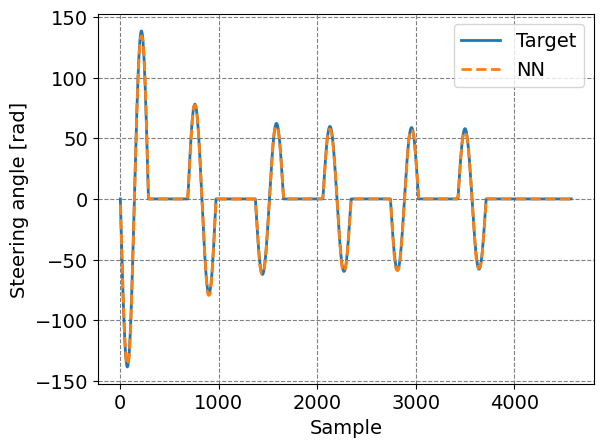

In [19]:
# Test on a new dataset
dataset_use = 'validation_set'
if dataset_use == 'training_set':
  num_samples_use = pd.read_csv(os.path.join(data_folder_train,'telem_train.csv'))['ay'].values.shape[0]-num_samples_future_feedfw
elif dataset_use == 'validation_set':
  num_samples_use = pd.read_csv(os.path.join(data_folder_valid,'telem_valid.csv'))['ay'].values.shape[0]-num_samples_future_feedfw
else:
  num_samples_use = 100
samples_test_set = steer_controller.getSamples(dataset_use, index=0, window=num_samples_use) 
out_nn_test_set  = steer_controller(samples_test_set, sampled=True)
out_nn_test_set_extract = np.asarray(out_nn_test_set['steering_angle'])

# Extract the samples
samples_test_set_extract = np.zeros((len(samples_test_set['steer_target']),1))
for i in range(0,len(samples_test_set_extract)):
  samples_test_set_extract[i] = samples_test_set['steer_target'][i]

# Compute the MSE on the test set
mse_calc = 0
for i in range(0,len(samples_test_set_extract)):
  mse_calc = mse_calc + (samples_test_set_extract[i] - out_nn_test_set_extract[i])**2 
rmse_calc = np.sqrt(mse_calc/len(samples_test_set_extract))
print('RMSE on the test set: ', np.rad2deg(rmse_calc), ' deg')

# Extract the outputs of the NN trained in Keras
out_nn_keras = np.zeros((len(samples_test_set['steer_target']),1))

flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot(np.rad2deg(samples_test_set_extract),label='Target',linewidth=2)
  plt.plot(np.rad2deg(out_nn_test_set_extract),label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Steering angle [rad]')
  plt.legend()
  plt.grid()
  plt.show()

# Test with custom data
#steer_controller_ARD({'curv':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],'steer':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]})